In [1]:
from tqdm import tqdm
from models import CompletionNetwork, ContextDiscriminator, GlobalDiscriminator_P
from datasets_inference import ImageDataset
from losses import completion_network_loss, completion_network_loss_P
from noise import AddGaussianNoise
from utils import (
    gen_input_mask,
    gen_hole_area,
    crop,
    sample_random_batch,
    poisson_blend,
    poisson_blend_m,
)
from torch.utils.data import DataLoader
from torch.optim import Adadelta, Adam
from torch.nn import BCELoss, DataParallel
from torchvision.utils import save_image
import torchvision.utils as vutils
from PIL import Image
import torchvision.transforms as transforms
import torch
import random
import os
import argparse
import numpy as np
import json
import time

import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
from multiprocessing import Process, Queue, Pool
import time
import sys

In [3]:
!pwd

/root/notebooks/final/pedestrian_generator


In [4]:
# data_path = "/root/notebooks/final/caltech_origin_mask2_20000"
# out_path = "/root/notebooks/final/caltech_origin_mask_20000/result_6-10_part2"

data_path = "/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000"

model_path = "/root/notebooks/pedestrian_generator_data/result_mask10/phase_3/1_model_cn_step20000"

out_path = "/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000"

In [5]:
sorted(glob.glob(data_path+'/people/*'), key=lambda x: x[-10:-3])[:10]

['/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000000.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000001.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000002.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000003.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000004.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000005.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000006.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000007.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000008.jpg',
 '/root/notebooks/pedestrian_generator_data/caltech_origin_mask10_100000/people/000009.jpg']

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default=data_path)
parser.add_argument('--result_dir', type=str, default=out_path)
parser.add_argument('--recursive_search', action='store_true', default=False)
parser.add_argument('--init_model_cn', type=str, default=model_path)
parser.add_argument('--init_model_cd', type=str, default=None)
parser.add_argument('--steps_1', type=int, default=8000)
parser.add_argument('--steps_2', type=int, default=4000)
parser.add_argument('--steps_3', type=int, default=3000)
parser.add_argument('--snaperiod_1', type=int, default=800)
parser.add_argument('--snaperiod_2', type=int, default=400)
parser.add_argument('--snaperiod_3', type=int, default=300)
parser.add_argument('--max_holes', type=int, default=1)
parser.add_argument('--hole_min_w', type=int, default=48)
parser.add_argument('--hole_max_w', type=int, default=96)
parser.add_argument('--hole_min_h', type=int, default=48)
parser.add_argument('--hole_max_h', type=int, default=96)
parser.add_argument('--cn_input_size', type=int, default=256)
parser.add_argument('--ld_input_size', type=int, default=256)
parser.add_argument('--optimizer', type=str, choices=['adadelta', 'adam'], default='adam')
parser.add_argument('--bsize', type=int, default=10)
parser.add_argument('--bdivs', type=int, default=1)
parser.add_argument('--data_parallel', action='store_true')
parser.add_argument('--num_test_completions', type=int, default=3)
parser.add_argument('--mpv', nargs=3, type=float, default=None)
parser.add_argument('--alpha', type=float, default=4e-3)
parser.add_argument('--arc', type=str, choices=['celeba', 'places2'], default='celeba')

parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [7]:
args = parser.parse_args()

In [8]:
# ================================================
# Preparation
# ================================================
args.data_dir = os.path.expanduser(args.data_dir)
args.result_dir = os.path.expanduser(args.result_dir)
if args.init_model_cn != None:
    args.init_model_cn = os.path.expanduser(args.init_model_cn)


if torch.cuda.is_available() == False:
    raise Exception('At least one gpu must be available.')
else:
    gpu = torch.device('cuda:0')

# create result directory (if necessary)
if os.path.exists(args.result_dir) == False:
    os.makedirs(args.result_dir)

    
#code below not used    
for s in ['output']:
    if os.path.exists(os.path.join(args.result_dir, s)) == False:
        os.makedirs(os.path.join(args.result_dir, s))


In [9]:
# imgs = np.einsum('klij->kjli', np.array(imgs))
# print(imgs.shape)

In [10]:
# inference dataset

trnsfm = transforms.Compose([
    transforms.ToTensor(),
    
])

trnsfm2 = transforms.Compose([
    transforms.ToTensor(),
])
print('loading dataset... (it may take a few minutes)')
train_dset = ImageDataset(args.data_dir, trnsfm,trnsfm2, load2meme = False)
train_loader = DataLoader(train_dset, batch_size=(args.bsize // args.bdivs), shuffle=False, num_workers=5)

alpha = torch.tensor(args.alpha).to(gpu)

loading dataset... (it may take a few minutes)


In [11]:
train_dset.__len__()

100

In [12]:
# Create model G

model_cn = CompletionNetwork()
if args.data_parallel:
    model_cn = DataParallel(model_cn)
    
if args.init_model_cn != None:
    model_cn.load_state_dict(torch.load(args.init_model_cn, map_location='cpu'))

    
model_cn = model_cn.to(gpu)


In [13]:
for street_img, mask_poeple, mask, img_names in train_loader:
        
    street_img = street_img.to(gpu)
    mask_poeple = mask_poeple.to(gpu)
    mask = mask

    input = torch.cat((street_img, mask_poeple), dim=1)
    with torch.no_grad():
        output = model_cn(input)

    mask_ = (mask).le(0.5).to(torch.uint8) * 255

    completed = poisson_blend(output, street_img, mask_)
    break

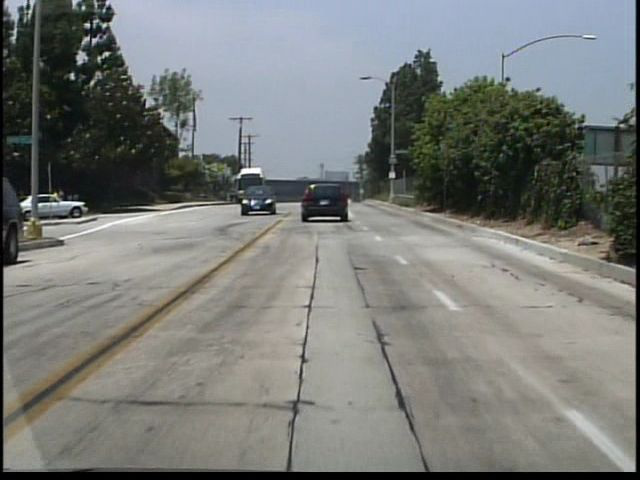

In [14]:
transforms.functional.to_pil_image(street_img.cpu()[5])

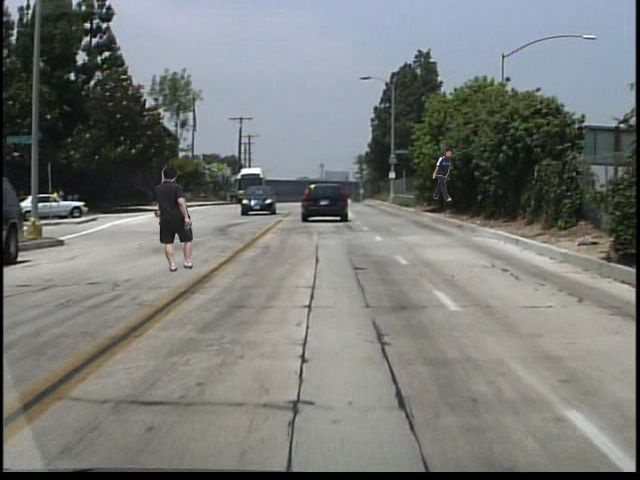

In [15]:
transforms.functional.to_pil_image(mask_poeple.cpu()[5])

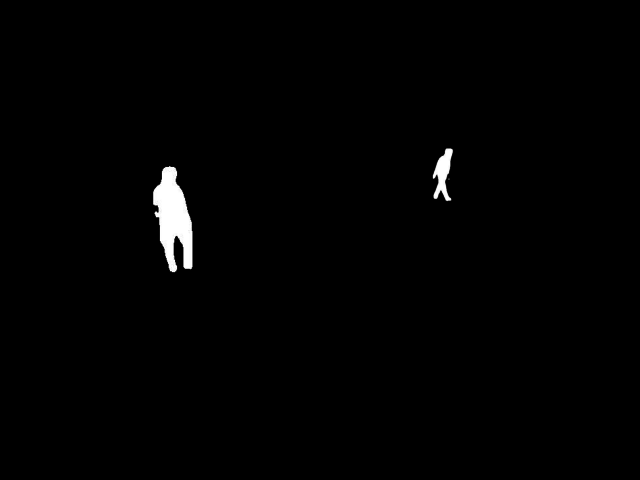

In [16]:
transforms.functional.to_pil_image(mask.cpu()[5])

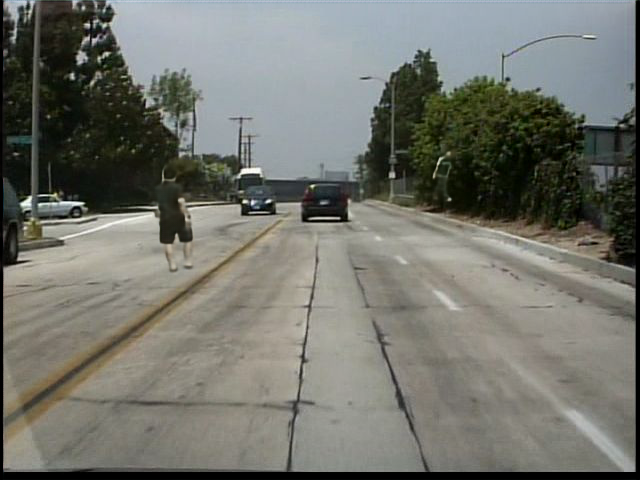

In [17]:
transforms.functional.to_pil_image(completed.cpu()[5])

In [18]:
# street_img_pil = Image.open(img_names[10])
# mask_pil = transPIL(mask[10]).convert("RGBA")
# completed_pil = transPIL(completed.cpu()[10]).convert("RGBA")

# street_img_pil.paste(completed_pil,(centers[10][0]-128,centers[10][1]-128),mask_pil)

# imgpath = str(img_names[10])
# # imgpath = imgpath.replace('street', 'output')
# # #print(imgpath)
# # save_image(img, '/root/notebooks/final/caltech_origin_mask2_20000/test.jpg')
# # street_img_pil.save('')

# street_img_pil.save('/root/notebooks/final/caltech_origin_mask2_20000/test.jpg')



In [19]:
# imgpath

In [20]:
transPIL = transforms.ToPILImage()

In [21]:

class saving_process():
    def __init__(self, length, num_process = 1):
        self.queue = Queue()
        self.length = length
        self.num_process = num_process
        self.pbar = None
        
    def push(self, data):
        #img, save_path = data
        self.queue.put(data)
        self.pbar.update()
        
        if(self.pbar.n >= self.length):
            self.pbar.close()
        
    def kill(self):
        for i in range(self.num_process+1):
            self.queue.put(['', 'DONE'])
        time.sleep(0.1)
        self.p.close()
        
    def process(self, queue):  
        _start = 0
        #pbar = tqdm(total=self.length)
        
        while True:
            try:
                img, save_path = queue.get()
                img.save(save_path)
                _start = time.time()
                
            except:
                time.sleep(0.2)
                if (time.time() - _start)> 600: # if prcess have no data come in for 10 min, kill it
                    print("Time out !!")
                    break

            if (save_path == 'DONE'):
                break
        #pbar.close()
                
    def start(self): 
        self.p = Pool(processes = self.num_process)
        self.p.apply_async(self.process, (self.queue,))
        #p.daemon = True
        
        self.pbar = tqdm(total=self.length)
        
        
        
#         for i in range(self.num_process):
#             sprocess = Process(target=self.process, args=((self.queue),))
#             sprocess.daemon = True
#             sprocess.start()
            #sprocess.join()
        

        

# def reader_proc(queue):
#     ## Read from the queue; this will be spawned as a separate Process
#     while True:
#         msg = queue.get()         # Read from the queue and do nothing
#         if (msg == 'DONE'):
#             break

# def writer(count, queue):
#     ## Write to the queue
#     for ii in range(0, count):
#         queue.put(ii)             # Write 'count' numbers into the queue
#     queue.put('DONE')

# if __name__=='__main__':
#     pqueue = Queue() # writer() writes to pqueue from _this_ process
#     for count in [10**4, 10**5, 10**6]:             
#         ### reader_proc() reads from pqueue as a separate process
#         reader_p = Process(target=reader_proc, args=((pqueue),))
#         reader_p.daemon = True
#         reader_p.start()        # Launch reader_proc() as a separate python process

#         _start = time.time()
#         writer(count, pqueue)    # Send a lot of stuff to reader()
#         reader_p.join()         # Wait for the reader to finish
#         print("Sending {0} numbers to Queue() took {1} seconds".format(count, 
#             (time.time() - _start)))

In [22]:
Pro = saving_process(length=train_dset.__len__(), num_process=10)
# Pro.start()
print("Start saving process.")

Start saving process.


In [23]:
def inference_G():
    cnt_bdivs = 0
    Pro.start()
    pbar = tqdm(total=len(train_loader))

    for street_img, mask_poeple, mask, img_names in train_loader:
        
        street_img = street_img.to(gpu)
        mask_poeple = mask_poeple.to(gpu)
        mask = mask

        input = torch.cat((street_img, mask_poeple), dim=1)
        with torch.no_grad():
            output = model_cn(input)
        mask_ = (mask).le(0.5).to(torch.uint8) * 255
        
        completed = poisson_blend_m(output, street_img, mask_)
        for i in range(len(completed)):
            img = completed[i]
            
            #street_img_pil = Image.open(img_names[i])
            #mask_pil = transPIL(mask[i]).convert("RGBA")
            #completed_pil = transPIL(completed.cpu()[i]).convert("RGB")
            
            #street_img_pil.paste(completed_pil,(centers[i][0]-128,centers[i][1]-128),mask_pil.convert("L"))
            
            street_img_pil = transforms.functional.to_pil_image(img)
            
            imgpath = str(img_names[i])
            imgpath = imgpath.replace('street', 'output')
            #print(imgpath)
            #save_image(img, imgpath)
            #street_img_pil.save(imgpath)
            Pro.push([street_img_pil, imgpath])
        pbar.update()
            
        #pbar.set_description('%d | phase 1 | train loss: %.5f' % (n,loss.cpu()))
        
    pbar.close()
    Pro.kill()


In [ ]:
inference_G()

  0%|          | 0/10 [00:00<?, ?it/s]

mm
mm
mm
mm
mm
mm
mmm
mmmm
mmm
mmm
mmmm
mm
mm
mmm
mmm
mmm
mmmm
mmmm
mmm
mmm
kk
mm
mmm
mmmm
kk
mmm
mm
mmm
kk
mmmm
mmm
kk
kk
kk


In [ ]:
# Pro.kill()